# <span style="color:#ffd3b6"> <center> DSIM, Assignment 3 - AA 2020/2021 </center>

> <span style="color:#a8e6cf">**Studente**:</span> Campironi Matteo
>
> <span style="color:#a8e6cf">**Matricola**:</span> 801850

Implement a script for image stitching of two images, following the guidelines shown in the notebook.

# <span style="color:#ffd3b6"> Importo le librerie e definisco alcune funzioni

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
plt.rcParams['figure.figsize'] = [10, 10]

Definisco una funzione che calcola l'omografia:

In [2]:
def myHomography(kps1, kps2, matches):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in matches ])
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in matches ])
    M, mask = cv.findHomography(dst_pts, src_pts, cv.RANSAC)
    return M

E una che applica l'omografia calcolata precedentemente alla mia immagine:

In [3]:
def myWarp(im, H, coord):
    return cv.warpPerspective(im, H, coord)

Definisco inoltre una funzione che permette di unire le foto in una sola finale:

In [4]:
def myCollage(im_base, im_new):
    im_base[0:im_new.shape[0],0:im_new.shape[1]] = im_new 
    return im_base

## <span style="color:#ffd3b6"> Carico e visualizzo le immagini

Decido inizialmente di lavorare in scala di grigi e di preoccuparmi successivamente del colore.

In [5]:
im1 = cv.imread('images/boat1.jpg', 0)
im2 = cv.imread('images/boat2.jpg', 0)

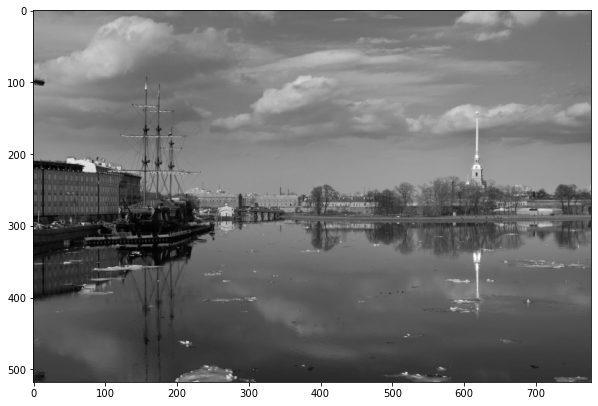

In [6]:
plt.imshow(im1, 'gray'); plt.show()

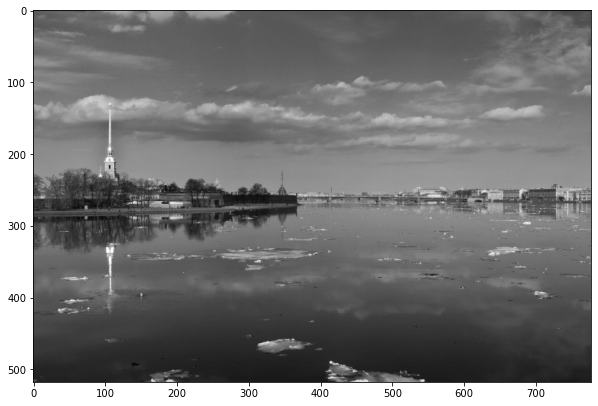

In [7]:
plt.imshow(im2, 'gray'); plt.show()

## <span style="color:#ffd3b6"> Cerco i keypoints delle immagini

Utilizzo SIFT per trovare i keypoints e li visualizzo per entrambe le immagini:

In [8]:
sift = cv.xfeatures2d.SIFT_create()
(kps1, features1) = sift.detectAndCompute(im1, None)
(kps2, features2) = sift.detectAndCompute(im2, None)

In [9]:
print(cv.__version__)

3.4.1


In [10]:
im1kps = cv.drawKeypoints(im1, kps1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
im2kps = cv.drawKeypoints(im2, kps2, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

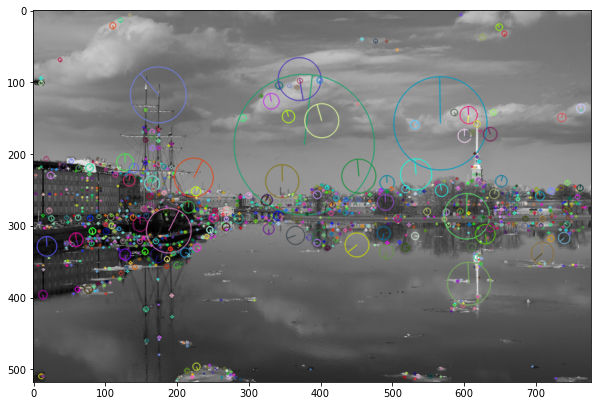

In [11]:
plt.imshow(im1kps, 'gray'); plt.show()

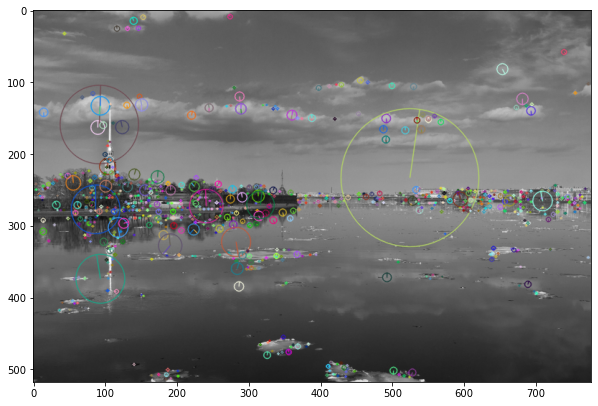

In [12]:
plt.imshow(im2kps, 'gray'); plt.show()

## <span style="color:#ffd3b6"> Creazione matches

Il passo successivo è creare i matches tra i keypoints:

In [13]:
bf = cv.BFMatcher(crossCheck=True)
matches = bf.match(features1, features2)

Per questione di visualizzazione decido di riordinare i matches in ordine decrescente di corrispondenza e di tenerne solo una parte:

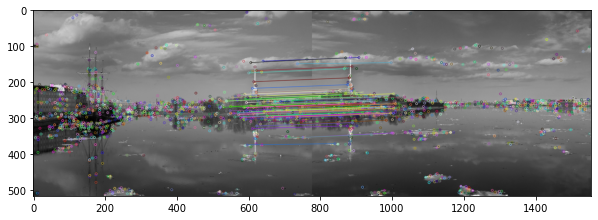

In [14]:
matches = sorted(matches, key=lambda x:x.distance)
sub_matches=int(len(matches)*0.2)

res = cv.drawMatches(im1, kps1, im2, kps2, matches[0:sub_matches], None)

plt.imshow(res, 'gray'); plt.show()

## <span style="color:#ffd3b6"> Calcolo e applicazione omografia

Uso la funzione `myHomography` definita inizialmente per calcolare l'omografia e successivamente utilizzo la funzione `myWarp` per applicarla sull'immagine.

In [15]:
H = myHomography(kps1, kps2, matches)

In [16]:
temp = myWarp(im2, H, (2000,800))

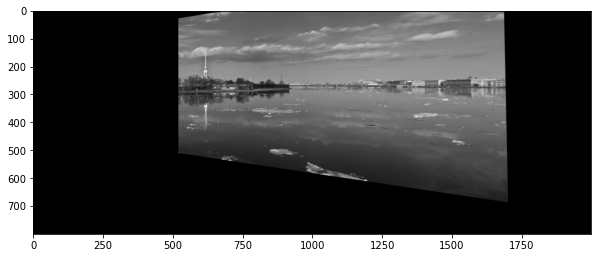

In [17]:
plt.imshow(temp, 'gray'); plt.show()

## <span style="color:#ffd3b6"> Risultato finale

Utilizzo la funzione `myCollage` per creare l'immagine finale:

In [18]:
temp = myCollage(temp, im1)

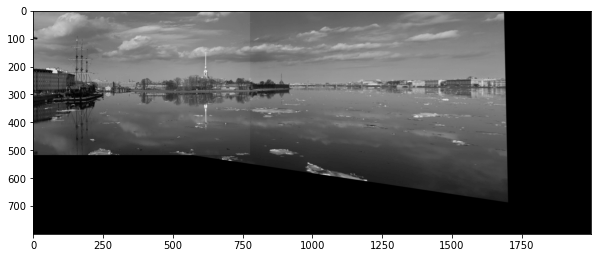

In [19]:
plt.imshow(temp, 'gray'); plt.show()

La procedura sembra essere andata a buon fine, ma come è possibile osservare sono presenti dei contorni neri. Questi sono dovuti alla funzione myWarp, che richiede delle dimensioni in input per generare lo spazio in cui andare a generare l'immagine a cui è stata applicata l'omografia. Inoltre è ancora da inserire la possibilità di utilizzare foto a colori.

Iniziamo a risolvere il primo problema, cercando di trovare un modo automatico per ritagliare le immagini.

## <span style="color:#ffd3b6"> Ritaglio automatico delle immagini

La funzione `cv.warpPerspective` richiede in input la dimensione dell'output dell'immagine. Per evitare di doverla inserire manualmente e per rimuovere gli eventuali bordi neri, calcolo le coordinate dei vertici dell'immagine dopo aver applicato l'omografia.

Siano $(0,0)$, $(0,w)$, $(h,0)$, $(h,w)$ i vertici della nostra immagine. 

<div style="width:image width px; 
            font-size:80%; 
            text-align:center; 
            float: left; padding-left-right-top-bottom:31em;  ">
    <img src="https://i.imgur.com/hTWE0qM.png" 
         width=800 
         style="padding-left:100px;"/>
    </div>
</div>


Definiamo $P$ come la seguente matrice delle coordinate:

$$\begin{bmatrix} 0 & w & w & 0 \\ 0 & 0 & h & h \\ 1 & 1 & 1 & 1 \end{bmatrix}$$

e consideriamo la matrice $P'$, data dal prodotto tra $H$ e $P$:

$$P'= \begin{bmatrix} h_{00} & h_{01} & h_{02} \\ h_{10} & h_{11} & h_{12} \\ h_{20} & h_{21} & 1 \end{bmatrix} \begin{bmatrix} 0 & w & w & 0 \\ 0 & 0 & h & h \\ 1 & 1 & 1 & 1 \end{bmatrix}$$

Allora per passare da coordinate omogenee a cartesiane, basterà dividere le prime righe della matrice per l'ultima. In questo modo otteniamo le coordinate dei vertici dopo l'applicazione dell'omografia ed è possibile eliminare i bordi neri dell'immagine.

In [20]:
h1 = im1.shape[0] 
w1 = im1.shape[1]
h2 = im2.shape[0] 
w2 = im2.shape[1]

P = [[0,w2,w2,0],[0,0,h2,h2],[1,1,1,1]]
P1 = np.dot(H,P)
X = P1[0,:]/P1[2,:]
Y = P1[1,:]/P1[2,:]

coord = (np.int64(min(X[1],X[2])),np.int64(max(Y[0],Y[3])))

In [21]:
temp = myWarp(im2, H, coord)

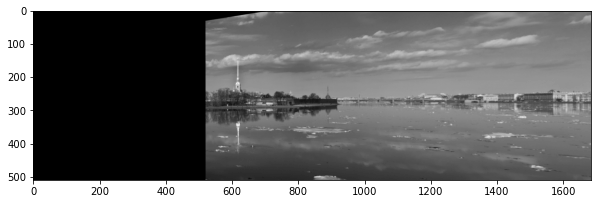

In [22]:
plt.imshow(temp, 'gray'); plt.show()

In [23]:
temp[0:min(h1,coord[1]),0:min(w1,coord[0])] = im1[0:min(h1,coord[1]),0:min(w1,coord[0])]

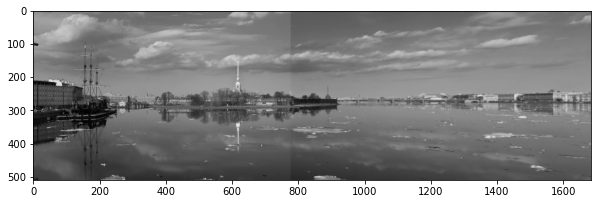

In [24]:
plt.imshow(temp, 'gray'); plt.show()

## <span style="color:#ffd3b6"> Aggiungo il colore

Matplotlib e OpenCV fanno uso dei tre canali RGB in ordine differente, di conseguenza nella visualizzazione del risultato otteniamo dei colori sfalsati:

In [25]:
im1 = cv.imread('images/boat1.jpg')

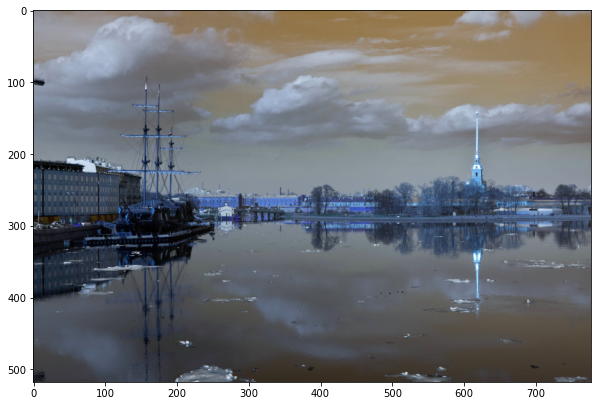

In [26]:
plt.imshow(im1, 'gray'); plt.show()

Basterà quindi riordinare i canali per ottenere la giusta rappresentazione:

In [27]:
b,g,r = cv.split(im1); im1 = cv.merge([r,g,b])

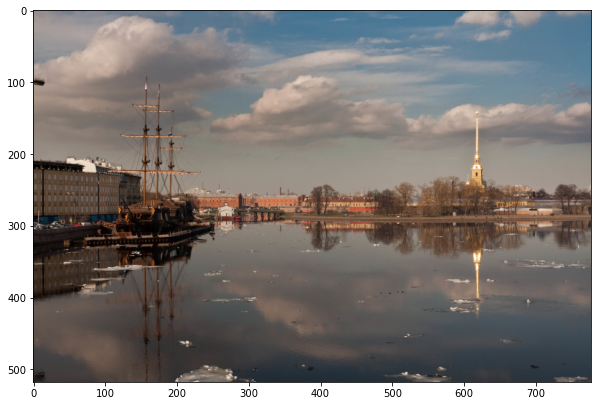

In [28]:
plt.imshow(im1, 'gray'); plt.show()

# <span style="color:#ffd3b6"> Definisco la funzione di image stitching completa

Definiamo quindi una funzione di image stitching che riassume quanto visto in questo notebook e testiamola:

In [29]:
def stitch(im1, im2, verticale=False):
    
    # Keypoints extraction
    sift = cv.xfeatures2d.SIFT_create()
    (kps1, features1) = sift.detectAndCompute(im1, None)
    (kps2, features2) = sift.detectAndCompute(im2, None)
    
    # Features matching
    bf = cv.BFMatcher(crossCheck=True)
    matches = bf.match(features1, features2)
    
    # Calculate homography
    H = myHomography(kps1, kps2, matches)
    
    # Calculate coordinates to use for the myWarp function 
    h1 = im1.shape[0] 
    w1 = im1.shape[1]
    h2 = im2.shape[0] 
    w2 = im2.shape[1]
    
    P = [[0,w2,w2,0],[0,0,h2,h2],[1,1,1,1]]
    P1 = np.dot(H,P)
    X = P1[0,:]/P1[2,:]
    Y = P1[1,:]/P1[2,:]
    
    if verticale==True:
        coord = (np.int64(min(X[1],X[2],w1)),np.int64(max(Y[0],Y[3],h1)))
    else:
        coord = (np.int64(min(X[1],X[2])),np.int64(max(Y[0],Y[3])))
    
    # Warping the image
    temp = myWarp(im2, H, coord)
    
    # Creating the final image
    temp[0:min(h1,coord[1]),0:min(w1,coord[0])] = im1[0:min(h1,coord[1]),0:min(w1,coord[0])]
    
    # Setting the right RGB channels order
    b,g,r = cv.split(temp); temp = cv.merge([r,g,b])
    
    return temp

# <span style="color:#ffd3b6"> Provo con due immagini diverse da quanto visto a lezione

In [30]:
plt.rcParams['figure.figsize'] = [15, 15]

### <span style="color:#a8e6cf"> Foto verticale

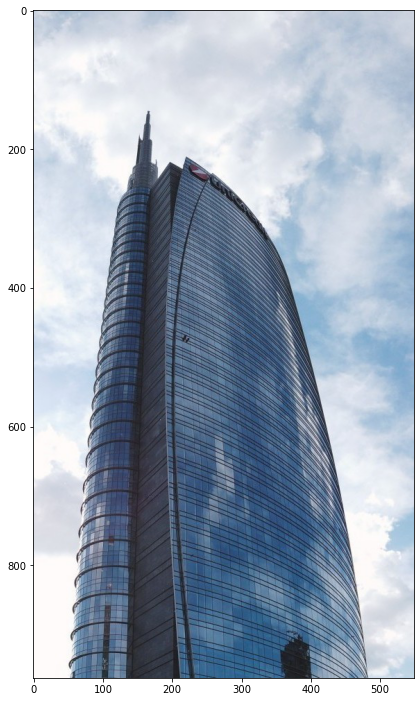

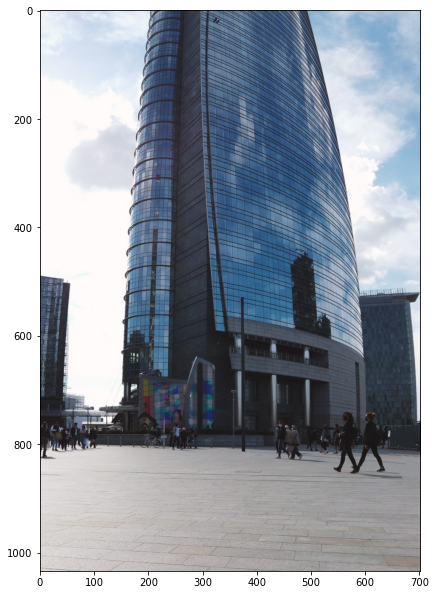

In [31]:
im1 = cv.imread('images/vert1.jpg')
im2 = cv.imread('images/vert2.jpg')
plt.subplot(1,2,1); plt.imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB)); plt.show()
plt.subplot(1,2,2); plt.imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB)); plt.show()

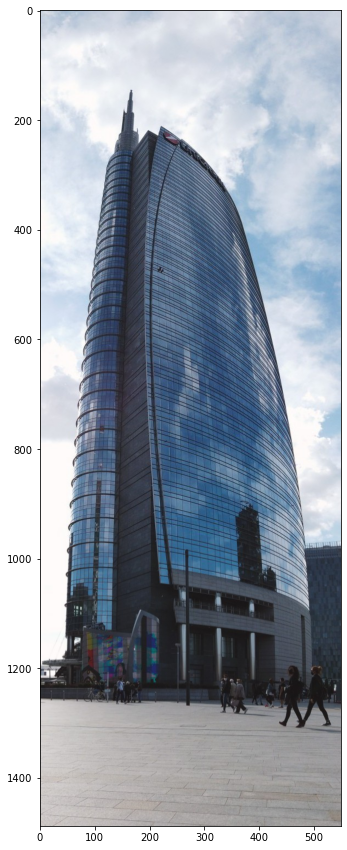

In [32]:
temp = stitch(im1, im2, verticale=True)
plt.imshow(temp); plt.show()

### <span style="color:#a8e6cf"> Foto orizzontale

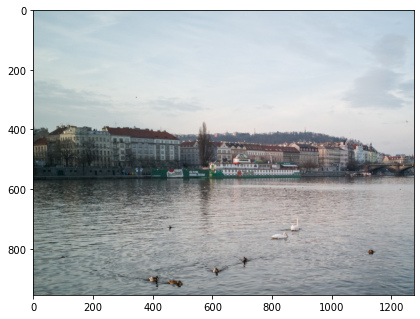

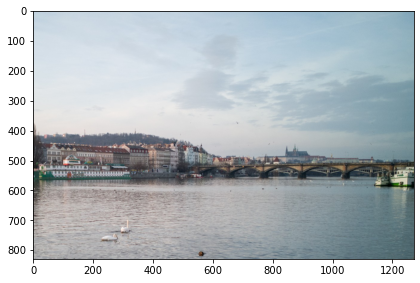

In [33]:
im1 = cv.imread('images/orizz1.jpg')
im2 = cv.imread('images/orizz2.jpg')
plt.subplot(1,2,1); plt.imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB)); plt.show()
plt.subplot(1,2,2); plt.imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB)); plt.show()

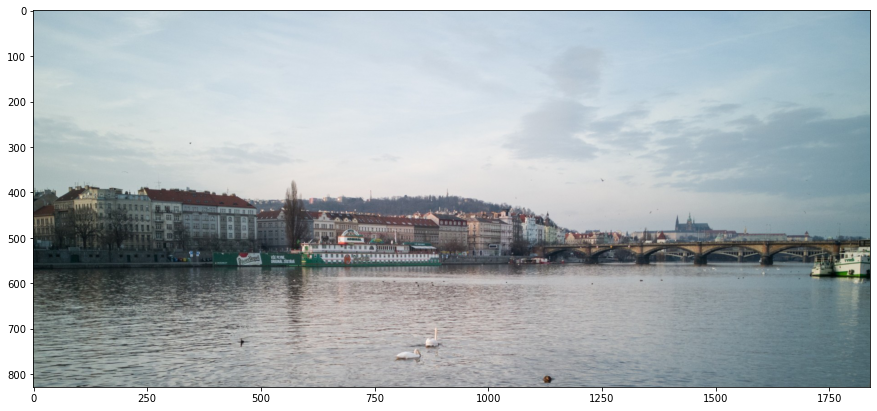

In [34]:
temp = stitch(im1, im2)
plt.imshow(temp); plt.show()